In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.notebook import tqdm
import random
import warnings
import time
import seaborn as sns
from scipy.stats import mannwhitneyu

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df_ratings = pd.read_csv("ratings.csv")
print('Ratings shape:', df_ratings.shape)
df_ratings.head()

Ratings shape: (100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
df_movies = pd.read_csv("movies.csv")
print('Ratings shape:', df_movies.shape)
df_movies.head()

Ratings shape: (87585, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
movie_review_counts = df_ratings['movieId'].value_counts()
movies_with_enough_reviews = movie_review_counts[movie_review_counts >= 20].index
df_ratings = df_ratings[df_ratings['movieId'].isin(movies_with_enough_reviews)]
df_movies = df_movies[df_movies['movieId'].isin(movies_with_enough_reviews)]

In [6]:
print('Ratings shape after exclusion:', df_ratings.shape)

Ratings shape after exclusion: (67898, 4)


In [7]:
print('Movies shape after exclusion:', df_movies.shape)

Movies shape after exclusion: (1297, 3)


In [8]:
df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


In [9]:
df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)')
df_movies['year'] = pd.to_numeric(df_movies['year'], errors='coerce')

In [10]:
df_movies_expanded = df_movies.assign(genres=df_movies['genres'].str.split('|')).explode('genres')
df_movies_expanded.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure,1995
0,1,Toy Story (1995),Animation,1995
0,1,Toy Story (1995),Children,1995
0,1,Toy Story (1995),Comedy,1995
0,1,Toy Story (1995),Fantasy,1995


In [11]:
df_ratings_2 = pd.merge(df_ratings, df_movies_expanded[['movieId', 'year', 'genres']], on='movieId', how='left')
df_ratings_2.head()

,userId,movieId,rating,timestamp,year,genres
0,1,1,4.0,2000-07-30 18:45:03,1995,Adventure
1,1,1,4.0,2000-07-30 18:45:03,1995,Animation
2,1,1,4.0,2000-07-30 18:45:03,1995,Children
3,1,1,4.0,2000-07-30 18:45:03,1995,Comedy
4,1,1,4.0,2000-07-30 18:45:03,1995,Fantasy


# Feature Engineering

In [12]:
df_ratings_2['oldness'] = pd.cut(
    df_ratings_2['year'], 
    bins=[-float('inf'), 1980, 2000, float('inf')], 
    labels=['old', 'medium', 'new']
)
df_ratings_2.head()

,userId,movieId,rating,timestamp,year,genres,oldness
0,1,1,4.0,2000-07-30 18:45:03,1995,Adventure,medium
1,1,1,4.0,2000-07-30 18:45:03,1995,Animation,medium
2,1,1,4.0,2000-07-30 18:45:03,1995,Children,medium
3,1,1,4.0,2000-07-30 18:45:03,1995,Comedy,medium
4,1,1,4.0,2000-07-30 18:45:03,1995,Fantasy,medium


In [13]:
def get_feature_by_user(df):
    res = list()
    for i, v in tqdm(df.groupby('userId')):

        # Remove duplicate user-movie pairs
        v2 = v.drop_duplicates(['userId', 'movieId'])[['userId', 'movieId', 'rating', 'oldness', 'timestamp']]
        avg_genre = v.groupby('genres')['rating'].mean()
        avg_oldness = v.groupby('oldness')['rating'].mean()
        res.append(
            (
                i,  # userId
                len(v2['movieId']),  # reviewed_products
                v2['rating'].sum(),  # ratings_sum
                v2['rating'].mean(),  # ratings_mean
                v2['rating'].var(),  # ratings_var

                (v2['rating'] == 5).sum() / v2.shape[0],  # 5_star_ratings_gave
                (v2['rating'] == 4).sum() / v2.shape[0],  # 4_star_ratings_gave
                (v2['rating'] == 3).sum() / v2.shape[0],  # 3_star_ratings_gave
                (v2['rating'] == 2).sum() / v2.shape[0],  # 2_star_ratings_gave
                (v2['rating'] == 1).sum() / v2.shape[0],  # 1_star_ratings_gave
                (v2['timestamp'].dt.dayofweek == 0).sum() / v2.shape[0],  # monday_review_user
                (v2['timestamp'].dt.dayofweek == 1).sum() / v2.shape[0],  # tuesday_review_user
                (v2['timestamp'].dt.dayofweek == 2).sum() / v2.shape[0],  # wednesday_review_user
                (v2['timestamp'].dt.dayofweek == 3).sum() / v2.shape[0],  # thursday_review_user
                (v2['timestamp'].dt.dayofweek == 4).sum() / v2.shape[0],  # friday_review_user
                (v2['timestamp'].dt.dayofweek == 5).sum() / v2.shape[0],  # saturday_review_user
                (v2['timestamp'].dt.dayofweek == 6).sum() / v2.shape[0],  # sunday_review_user
                (v2['timestamp'].dt.dayofweek >= 5).sum(),  # weekend_review_user
                (v2['timestamp'].dt.hour > 17).sum() / v2.shape[0],  # evening_reviews_by_user
                avg_genre.get('Action', float('nan')),  # avg_action
                avg_genre.get('Adventure', float('nan')),  # avg_adventure
                avg_genre.get('Animation', float('nan')),  # avg_animation
                avg_genre.get('Children', float('nan')),  # avg_children
                avg_genre.get('Comedy', float('nan')),  # avg_comedy
                avg_genre.get('Crime', float('nan')),  # avg_crime
                avg_genre.get('Drama', float('nan')),  # avg_drama
                avg_genre.get('Fantasy', float('nan')),  # avg_fantasy
                avg_genre.get('Horror', float('nan')),  # avg_horror
                avg_genre.get('IMAX', float('nan')),  # avg_imax
                avg_genre.get('Musical', float('nan')),  # avg_musical
                avg_genre.get('Mystery', float('nan')),  # avg_mystery
                avg_genre.get('Romance', float('nan')),  # avg_romance
                avg_genre.get('Sci-Fi', float('nan')),  # avg_scifi
                avg_genre.get('Thriller', float('nan')),  # avg_thriller
                avg_genre.get('War', float('nan')),  # avg_war
                avg_oldness.get('old', float('nan')),  # avg_old
                avg_oldness.get('medium', float('nan')),  # avg_medium
                avg_oldness.get('new', float('nan'))  # avg_new
            )
        )

    res = pd.DataFrame(
        res,
        columns=[
            'userId', 'reviewed_products', 'ratings_sum_user', 'ratings_mean_user', 'ratings_var_user',
            '5_star_ratings_gave', '4_star_ratings_gave', '3_star_ratings_gave', '2_star_ratings_gave', '1_star_ratings_gave',
            'monday_review_user', 'tuesday_review_user', 'wednesday_review_user', 'thursday_review_user',
            'friday_review_user', 'saturday_review_user', 'sunday_review_user', 'weekend_review_user', 'evening_reviews_by_user',
            'avg_action', 'avg_adventure', 'avg_animation', 'avg_children', 'avg_comedy', 'avg_crime',
            'avg_drama', 'avg_fantasy', 'avg_horror', 'avg_imax', 'avg_musical', 'avg_mystery',
            'avg_romance', 'avg_scifi', 'avg_thriller', 'avg_war', 'avg_old', 'avg_medium', 'avg_new'
        ]
    )
    return res


In [14]:
def get_feature_by_product(df):
    res = list()
    for i, v in tqdm(df.groupby('movieId')):

        # Remove duplicate user-movie pairs
        v2 = v.drop_duplicates(['userId', 'movieId'])[['userId', 'movieId', 'rating', 'year', 'timestamp']]
        
        res.append(
            (
                i,  # movieId
                len(v2['userId']),  # user_count
                v2['year'].mode()[0] if not v2['year'].isna().all() else float('nan'),  # mode of the year (if available)
                v2['rating'].sum(),  # ratings_sum
                v2['rating'].mean(),  # ratings_mean
                v2['rating'].var(),  # ratings_var
                (v2['rating'] == 5).sum() / v2.shape[0],  # 5_star_ratings_recieved
                (v2['rating'] == 4).sum() / v2.shape[0],  # 4_star_ratings_recieved
                (v2['rating'] == 3).sum() / v2.shape[0],  # 3_star_ratings_recieved
                (v2['rating'] == 2).sum() / v2.shape[0],  # 2_star_ratings_recieved
                (v2['rating'] == 1).sum() / v2.shape[0],  # 1_star_ratings_recieved
                (v2['timestamp'].dt.dayofweek == 0).sum() / v2.shape[0],  # monday_review_item
                (v2['timestamp'].dt.dayofweek == 1).sum() / v2.shape[0],  # tuesday_review_item
                (v2['timestamp'].dt.dayofweek == 2).sum() / v2.shape[0],  # wednesday_review_item
                (v2['timestamp'].dt.dayofweek == 3).sum() / v2.shape[0],  # thursday_review_item
                (v2['timestamp'].dt.dayofweek == 4).sum() / v2.shape[0],  # friday_review_item
                (v2['timestamp'].dt.dayofweek == 5).sum() / v2.shape[0],  # saturday_review_item
                (v2['timestamp'].dt.dayofweek == 6).sum() / v2.shape[0],  # sunday_review_item
                (v2['timestamp'].dt.hour > 17).sum() / v2.shape[0]  # evening_reviews_by_movie
            )
        )

    res = pd.DataFrame(
        res,
        columns=[
            'movieId', 'user_count', 'year', 'ratings_sum_movie', 'ratings_mean_movie', 'ratings_var_movie',
            '5_star_ratings_recieved', '4_star_ratings_recieved', '3_star_ratings_recieved',
            '2_star_ratings_recieved', '1_star_ratings_recieved',
            'monday_review_item', 'tuesday_review_item', 'wednesday_review_item', 'thursday_review_item',
            'friday_review_item', 'saturday_review_item', 'sunday_review_item', 'evening_reviews_by_movie'
        ]
    )
    return res


In [15]:
user_features = get_feature_by_user(df_ratings_2)
movie_features = get_feature_by_product(df_ratings_2)

  0%|          | 0/610 [00:00<?, ?it/s]

  0%|          | 0/1297 [00:00<?, ?it/s]

In [16]:
user_features.head()

,userId,reviewed_products,ratings_sum_user,ratings_mean_user,ratings_var_user,5_star_ratings_gave,4_star_ratings_gave,3_star_ratings_gave,2_star_ratings_gave,1_star_ratings_gave,...,avg_imax,avg_musical,avg_mystery,avg_romance,avg_scifi,avg_thriller,avg_war,avg_old,avg_medium,avg_new
0,1,181,798.0,4.408840,0.620810,0.563536,0.309392,0.104972,0.016575,0.005525,...,NaN,4.777778,4.4,4.277778,4.243243,4.276596,4.500000,4.697674,4.289474,NaN
1,2,23,90.5,3.934783,0.461462,0.130435,0.347826,0.130435,0.000000,0.000000,...,3.750000,NaN,4.0,4.500000,3.875000,3.888889,4.500000,NaN,3.875000,3.965517
2,3,22,34.5,1.568182,2.911797,0.090909,0.045455,0.045455,0.045455,0.000000,...,NaN,0.500000,NaN,0.500000,3.250000,3.625000,0.500000,0.794118,2.341463,0.500000
3,4,138,492.0,3.565217,1.809584,0.297101,0.326087,0.144928,0.108696,0.123188,...,3.000000,4.076923,3.0,3.421053,2.727273,3.384615,3.000000,4.647727,3.167331,3.000000
4,5,41,148.0,3.609756,0.993902,0.219512,0.292683,0.390244,0.073171,0.024390,...,3.666667,4.400000,4.0,3.000000,2.500000,3.555556,3.333333,5.000000,3.508929,NaN


In [17]:
movie_features.head()

,movieId,user_count,year,ratings_sum_movie,ratings_mean_movie,ratings_var_movie,5_star_ratings_recieved,4_star_ratings_recieved,3_star_ratings_recieved,2_star_ratings_recieved,1_star_ratings_recieved,monday_review_item,tuesday_review_item,wednesday_review_item,thursday_review_item,friday_review_item,saturday_review_item,sunday_review_item,evening_reviews_by_movie
0,1,215,1995,843.0,3.920930,0.696990,0.218605,0.381395,0.158140,0.027907,0.000000,0.195349,0.144186,0.116279,0.111628,0.176744,0.097674,0.158140,0.316279
1,2,110,1995,377.5,3.431818,0.777419,0.063636,0.327273,0.254545,0.045455,0.009091,0.145455,0.172727,0.090909,0.090909,0.218182,0.090909,0.190909,0.318182
2,3,52,1995,169.5,3.259615,1.112651,0.115385,0.230769,0.384615,0.038462,0.057692,0.153846,0.211538,0.134615,0.076923,0.192308,0.115385,0.115385,0.307692
3,5,49,1995,150.5,3.071429,0.822917,0.061224,0.163265,0.510204,0.122449,0.000000,0.142857,0.183673,0.102041,0.142857,0.122449,0.102041,0.204082,0.224490
4,6,102,1995,402.5,3.946078,0.667856,0.235294,0.362745,0.225490,0.019608,0.009804,0.117647,0.156863,0.166667,0.127451,0.147059,0.098039,0.186275,0.284314


In [18]:
df = pd.merge(df_ratings, user_features, on=['userId'])    
df = pd.merge(df, movie_features, on=['movieId'])
df.head()

,userId,movieId,rating,timestamp,reviewed_products,ratings_sum_user,ratings_mean_user,ratings_var_user,5_star_ratings_gave,4_star_ratings_gave,...,2_star_ratings_recieved,1_star_ratings_recieved,monday_review_item,tuesday_review_item,wednesday_review_item,thursday_review_item,friday_review_item,saturday_review_item,sunday_review_item,evening_reviews_by_movie
0,1,1,4.0,2000-07-30 18:45:03,181,798.0,4.40884,0.62081,0.563536,0.309392,...,0.027907,0.000000,0.195349,0.144186,0.116279,0.111628,0.176744,0.097674,0.158140,0.316279
1,1,3,4.0,2000-07-30 18:20:47,181,798.0,4.40884,0.62081,0.563536,0.309392,...,0.038462,0.057692,0.153846,0.211538,0.134615,0.076923,0.192308,0.115385,0.115385,0.307692
2,1,6,4.0,2000-07-30 18:37:04,181,798.0,4.40884,0.62081,0.563536,0.309392,...,0.019608,0.009804,0.117647,0.156863,0.166667,0.127451,0.147059,0.098039,0.186275,0.284314
3,1,47,5.0,2000-07-30 19:03:35,181,798.0,4.40884,0.62081,0.563536,0.309392,...,0.039409,0.009852,0.177340,0.152709,0.108374,0.147783,0.128079,0.118227,0.167488,0.290640
4,1,50,5.0,2000-07-30 18:48:51,181,798.0,4.40884,0.62081,0.563536,0.309392,...,0.014706,0.009804,0.156863,0.171569,0.132353,0.127451,0.161765,0.098039,0.151961,0.333333


In [19]:
feature_list = [col for col in df.columns if col not in ['userId', 'movieId', 'rating', 'timestamp']]
target = 'rating'

In [20]:
feature_list

['reviewed_products',
 'ratings_sum_user',
 'ratings_mean_user',
 'ratings_var_user',
 '5_star_ratings_gave',
 '4_star_ratings_gave',
 '3_star_ratings_gave',
 '2_star_ratings_gave',
 '1_star_ratings_gave',
 'monday_review_user',
 'tuesday_review_user',
 'wednesday_review_user',
 'thursday_review_user',
 'friday_review_user',
 'saturday_review_user',
 'sunday_review_user',
 'weekend_review_user',
 'evening_reviews_by_user',
 'avg_action',
 'avg_adventure',
 'avg_animation',
 'avg_children',
 'avg_comedy',
 'avg_crime',
 'avg_drama',
 'avg_fantasy',
 'avg_horror',
 'avg_imax',
 'avg_musical',
 'avg_mystery',
 'avg_romance',
 'avg_scifi',
 'avg_thriller',
 'avg_war',
 'avg_old',
 'avg_medium',
 'avg_new',
 'user_count',
 'year',
 'ratings_sum_movie',
 'ratings_mean_movie',
 'ratings_var_movie',
 '5_star_ratings_recieved',
 '4_star_ratings_recieved',
 '3_star_ratings_recieved',
 '2_star_ratings_recieved',
 '1_star_ratings_recieved',
 'monday_review_item',
 'tuesday_review_item',
 'wednesda

In [21]:
df = df.set_index(['userId', 'movieId'])
df = df[feature_list+[target]]

In [22]:
df.head()

reviewed_products  ratings_sum_user  ratings_mean_user  \
userId movieId                                                           
1      1                      181             798.0            4.40884   
       3                      181             798.0            4.40884   
       6                      181             798.0            4.40884   
       47                     181             798.0            4.40884   
       50                     181             798.0            4.40884   

                ratings_var_user  5_star_ratings_gave  4_star_ratings_gave  \
userId movieId                                                               
1      1                 0.62081             0.563536             0.309392   
       3                 0.62081             0.563536             0.309392   
       6                 0.62081             0.563536             0.309392   
       47                0.62081             0.563536             0.309392   
       50                0.62081             0.563536             0.309392   

                3_star_ratings_gave  2_star_ratings_gave  1_star_ratings_gave  \
userId movieId                                                                  
1      1                   0.104972             0.016575             0.005525   
       3                   0.104972             0.016575             0.005525   
       6                   0.104972             0.016575             0.005525   
       47                  0.104972             0.016575             0.005525   
       50                  0.104972             0.016575             0.005525   

                monday_review_user  ...  1_star_ratings_recieved  \
userId movieId                      ...                            
1      1                       0.0  ...                 0.000000   
       3                       0.0  ...                 0.057692   
       6                       0.0  ...                 0.009804   
       47                      0.0  ...                 0.009852   
       50                      0.0  ...                 0.009804   

                monday_review_item  tuesday_review_item  \
userId movieId                                            
1      1                  0.195349             0.144186   
       3                  0.153846             0.211538   
       6                  0.117647             0.156863   
       47                 0.177340             0.152709   
       50                 0.156863             0.171569   

                wednesday_review_item  thursday_review_item  \
userId movieId                                                
1      1                     0.116279              0.111628   
       3                     0.134615              0.076923   
       6                     0.166667              0.127451   
       47                    0.108374              0.147783   
       50                    0.132353              0.127451   

                friday_review_item  saturday_review_item  sunday_review_item  \
userId movieId                                                                 
1      1                  0.176744              0.097674            0.158140   
       3                  0.192308              0.115385            0.115385   
       6                  0.147059              0.098039            0.186275   
       47                 0.128079              0.118227            0.167488   
       50                 0.161765              0.098039            0.151961   

                evening_reviews_by_movie  rating  
userId movieId                                    
1      1                        0.316279     4.0  
       3                        0.307692     4.0  
       6                        0.284314     4.0  
       47                       0.290640     5.0  
       50                       0.333333     5.0  

[5 rows x 56 columns]

# Preprocessing

In [23]:
print(df.isnull().mean())

reviewed_products           0.000000
ratings_sum_user            0.000000
ratings_mean_user           0.000000
ratings_var_user            0.000000
5_star_ratings_gave         0.000000
4_star_ratings_gave         0.000000
3_star_ratings_gave         0.000000
2_star_ratings_gave         0.000000
1_star_ratings_gave         0.000000
monday_review_user          0.000000
tuesday_review_user         0.000000
wednesday_review_user       0.000000
thursday_review_user        0.000000
friday_review_user          0.000000
saturday_review_user        0.000000
sunday_review_user          0.000000
weekend_review_user         0.000000
evening_reviews_by_user     0.000000
avg_action                  0.000265
avg_adventure               0.001429
avg_animation               0.052756
avg_children                0.034434
avg_comedy                  0.000280
avg_crime                   0.004507
avg_drama                   0.000000
avg_fantasy                 0.013020
avg_horror                  0.040075
a

In [24]:
for col in df.columns:
    df[col] = df[col].fillna(np.mean(df[col]))

In [25]:
print(df.isnull().mean())

reviewed_products           0.0
ratings_sum_user            0.0
ratings_mean_user           0.0
ratings_var_user            0.0
5_star_ratings_gave         0.0
4_star_ratings_gave         0.0
3_star_ratings_gave         0.0
2_star_ratings_gave         0.0
1_star_ratings_gave         0.0
monday_review_user          0.0
tuesday_review_user         0.0
wednesday_review_user       0.0
thursday_review_user        0.0
friday_review_user          0.0
saturday_review_user        0.0
sunday_review_user          0.0
weekend_review_user         0.0
evening_reviews_by_user     0.0
avg_action                  0.0
avg_adventure               0.0
avg_animation               0.0
avg_children                0.0
avg_comedy                  0.0
avg_crime                   0.0
avg_drama                   0.0
avg_fantasy                 0.0
avg_horror                  0.0
avg_imax                    0.0
avg_musical                 0.0
avg_mystery                 0.0
avg_romance                 0.0
avg_scif

In [26]:
df = df.astype('float32')

# Training

### Functions for training

In [27]:
class Basic_Model(nn.Module):
    def __init__(self, input_size):
        super(Basic_Model, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.fc(x)

In [28]:
class Complex_Model(nn.Module):
    def __init__(self, input_size, dropout):
        super(Complex_Model, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.fc(x)

In [29]:
def train_and_evaluate(model, df, learning_rate, weight_decay):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move the model to GPU if available

    # Split the dataset
    train_val_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
    train_df, validation_df = train_test_split(train_val_df, test_size=0.1765, random_state=42)

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    num_epochs = 50
    batch_size = 64
    n_samples = len(train_df)

    X = torch.tensor(train_df.drop('rating', axis=1).values, dtype=torch.float32).to(device)
    y = torch.tensor(train_df['rating'].values, dtype=torch.float32).to(device)
    X_val = torch.tensor(validation_df.drop('rating', axis=1).values, dtype=torch.float32).to(device)
    y_val = torch.tensor(validation_df['rating'].values, dtype=torch.float32).to(device)

    # Initialize tracking variables
    train_loss = []
    validation_loss = []
    train_error = []
    validation_error = []

    start = time.time()

    for epoch in range(num_epochs):
        # Shuffle training data
        permutation = torch.randperm(n_samples)
        total_train_loss = 0.0
        absolute_errors = []
        absolute_errors_val = []

        for i in range(0, n_samples, batch_size):
            indices = permutation[i:i + batch_size]
            batch_X, batch_y = X[indices], y[indices]

            # Forward pass
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate batch loss
            total_train_loss += loss.item()
            # Track absolute errors for MAE calculation
            absolute_errors.extend(torch.abs(predictions - batch_y).view(-1).tolist())

        # Average training loss and MAE for the epoch
        avg_train_loss = total_train_loss / ((len(df) + 64 - 1) // 64)
        train_loss.append(avg_train_loss)
        #absolute_errors.extend(torch.abs(predictions - batch_y).view(-1).tolist())
        train_error.append(np.mean(absolute_errors))

        with torch.no_grad():
            predictions_val = model(X_val)
            loss_val = criterion(predictions_val, y_val)
            validation_loss.append(loss_val.item())

            # Compute MAE for validation
            #absolute_errors_val = torch.abs(predictions_val - y_val).tolist()
            absolute_errors_val = torch.abs(predictions_val - y_val).view(-1).tolist()
            validation_error.append(np.mean(absolute_errors_val))

        # Print metrics every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, ' +
                  f'Train Loss: {avg_train_loss:.4f}, ' +
                  f'Validation Loss: {loss_val.item():.4f}, ' +
                  f'Train MAE: {train_error[-1]:.4f}, ' +
                  f'Validation MAE: {validation_error[-1]:.4f}')
            
    # Test evaluation
    X_test = torch.tensor(test_df.drop('rating', axis=1).values, dtype=torch.float32).to(device)
    y_test = torch.tensor(test_df['rating'].values, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        test_loss = criterion(predictions, y_test)
        
    test_mae = mean_absolute_error(y_test.cpu().numpy(), predictions.cpu().numpy())
    print(f"Test MAE: {mean_absolute_error(y_test.cpu().numpy(), predictions.cpu().numpy()):.4f}")
    print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test.cpu().numpy(), predictions.cpu().numpy())):.4f}")

    end = time.time()
    print("Elapsed time:", end - start)

    # Plot training and validation loss
    plt.figure(figsize=(6, 3))
    plt.plot(train_loss, label='Train Loss', lw=3)
    plt.plot(validation_loss, label='Validation Loss', lw=3)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

    # Return the last validation MAE and validation loss
    return validation_error, validation_loss, train_error, train_loss, test_mae


### Hyperparameter ranges

In [34]:
lr_list = [random.uniform(0.001,  0.1) for _ in range(4)]
weight_decay_list = [random.uniform(0.0001,  0.0002) for _ in range(3)]
dropout_list = [random.uniform(0.3,  0.55) for _ in range(3)]

### Basic Model

In [36]:
input_size = len(feature_list)

Model Number: 1
Learning Rate: 0.06031190279803947
Weight Decay: 0.00014872540206663904
Epoch 1/50, Train Loss: 413.2840, Validation Loss: 1.0756, Train MAE: 2.5255, Validation MAE: 0.8265
Epoch 11/50, Train Loss: 0.5968, Validation Loss: 1.0078, Train MAE: 0.8102, Validation MAE: 0.7999
Epoch 21/50, Train Loss: 0.5853, Validation Loss: 1.0084, Train MAE: 0.8039, Validation MAE: 0.8015
Epoch 31/50, Train Loss: 0.5843, Validation Loss: 1.0078, Train MAE: 0.8024, Validation MAE: 0.8000
Epoch 41/50, Train Loss: 1.5384, Validation Loss: 1.0079, Train MAE: 0.8665, Validation MAE: 0.7994
Test MAE: 0.8017
Test RMSE: 1.0121
Elapsed time: 253.3966042995453


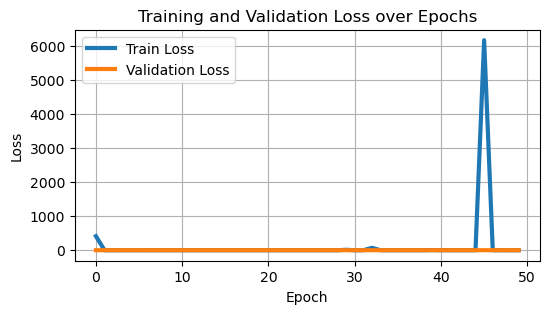

Model Number: 2
Learning Rate: 0.06031190279803947
Weight Decay: 0.00016289762118042547
Epoch 1/50, Train Loss: 363.4423, Validation Loss: 1.0238, Train MAE: 2.1678, Validation MAE: 0.7934
Epoch 11/50, Train Loss: 0.5849, Validation Loss: 1.0265, Train MAE: 0.8035, Validation MAE: 0.8133
Epoch 21/50, Train Loss: 0.5853, Validation Loss: 1.0078, Train MAE: 0.8032, Validation MAE: 0.8005
Epoch 31/50, Train Loss: 0.5859, Validation Loss: 1.0100, Train MAE: 0.8039, Validation MAE: 0.8027
Epoch 41/50, Train Loss: 0.5850, Validation Loss: 1.0091, Train MAE: 0.8038, Validation MAE: 0.7980
Test MAE: 1.3152
Test RMSE: 1.5087
Elapsed time: 253.15075945854187


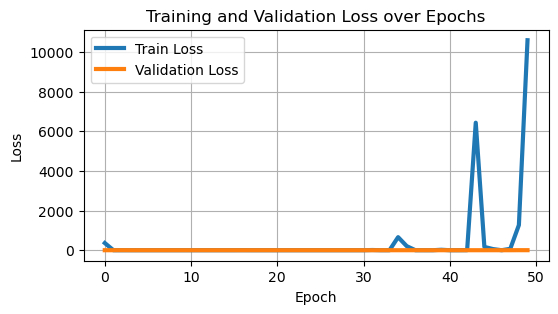

Model Number: 3
Learning Rate: 0.06031190279803947
Weight Decay: 0.00010287010923164324
Epoch 1/50, Train Loss: 477.1066, Validation Loss: 4.0754, Train MAE: 3.0078, Validation MAE: 1.7077
Epoch 11/50, Train Loss: 0.6133, Validation Loss: 1.0224, Train MAE: 0.8181, Validation MAE: 0.8097
Epoch 21/50, Train Loss: 0.5853, Validation Loss: 1.0113, Train MAE: 0.8033, Validation MAE: 0.8035
Epoch 31/50, Train Loss: 0.5849, Validation Loss: 1.0084, Train MAE: 0.8037, Validation MAE: 0.7987
Epoch 41/50, Train Loss: 0.5830, Validation Loss: 1.0089, Train MAE: 0.8037, Validation MAE: 0.7982
Test MAE: 0.8069
Test RMSE: 1.0067
Elapsed time: 251.4770004749298


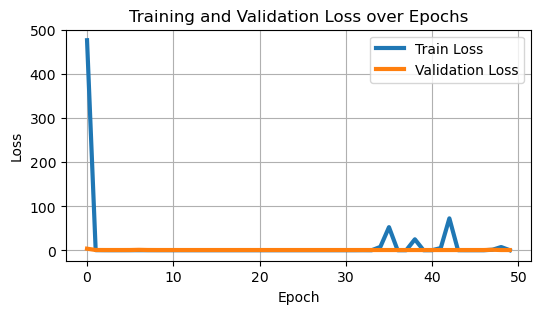

Model Number: 4
Learning Rate: 0.019423344365243327
Weight Decay: 0.00014872540206663904
Epoch 1/50, Train Loss: 42.6132, Validation Loss: 1.0103, Train MAE: 1.4264, Validation MAE: 0.8016
Epoch 11/50, Train Loss: 0.6025, Validation Loss: 1.1268, Train MAE: 0.8116, Validation MAE: 0.8782
Epoch 21/50, Train Loss: 0.5836, Validation Loss: 1.0078, Train MAE: 0.8035, Validation MAE: 0.8000
Epoch 31/50, Train Loss: 0.5859, Validation Loss: 1.0078, Train MAE: 0.8050, Validation MAE: 0.8001
Epoch 41/50, Train Loss: 0.5878, Validation Loss: 1.0223, Train MAE: 0.8052, Validation MAE: 0.7934
Test MAE: 0.8061
Test RMSE: 1.0068
Elapsed time: 251.739999294281


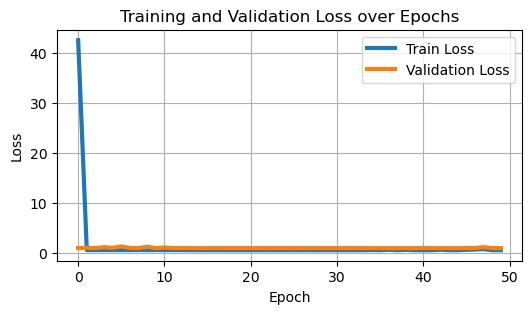

Model Number: 5
Learning Rate: 0.019423344365243327
Weight Decay: 0.00016289762118042547
Epoch 1/50, Train Loss: 25.2486, Validation Loss: 1.0166, Train MAE: 1.2192, Validation MAE: 0.7955
Epoch 11/50, Train Loss: 0.5956, Validation Loss: 1.0184, Train MAE: 0.8085, Validation MAE: 0.8064
Epoch 21/50, Train Loss: 0.5924, Validation Loss: 1.0079, Train MAE: 0.8077, Validation MAE: 0.7994
Epoch 31/50, Train Loss: 0.6204, Validation Loss: 1.0078, Train MAE: 0.8111, Validation MAE: 0.8002
Epoch 41/50, Train Loss: 0.5839, Validation Loss: 1.0078, Train MAE: 0.8034, Validation MAE: 0.8004
Test MAE: 0.8075
Test RMSE: 1.0067
Elapsed time: 251.0850007534027


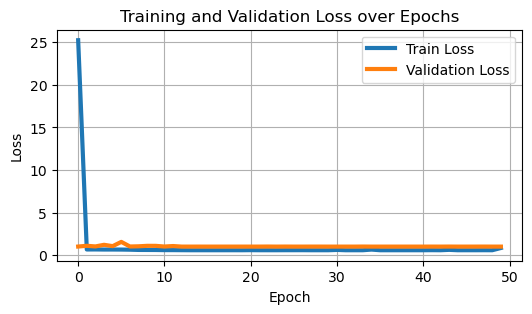

Model Number: 6
Learning Rate: 0.019423344365243327
Weight Decay: 0.00010287010923164324
Epoch 1/50, Train Loss: 14.6972, Validation Loss: 1.0294, Train MAE: 1.2046, Validation MAE: 0.7922
Epoch 11/50, Train Loss: 0.6051, Validation Loss: 1.0373, Train MAE: 0.8133, Validation MAE: 0.7906
Epoch 21/50, Train Loss: 0.5935, Validation Loss: 1.0112, Train MAE: 0.8072, Validation MAE: 0.7968
Epoch 31/50, Train Loss: 0.5837, Validation Loss: 1.0088, Train MAE: 0.8036, Validation MAE: 0.8019
Epoch 41/50, Train Loss: 2.3740, Validation Loss: 1.0078, Train MAE: 0.8902, Validation MAE: 0.8002
Test MAE: 0.8073
Test RMSE: 1.0067
Elapsed time: 251.02499961853027


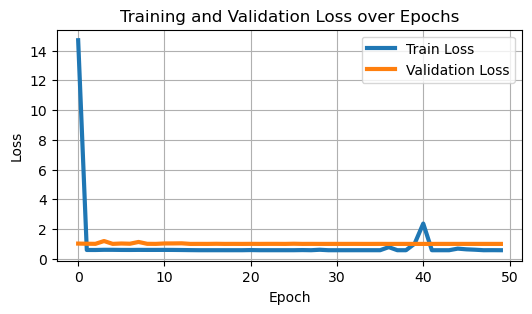

Model Number: 7
Learning Rate: 0.06513594792270827
Weight Decay: 0.00014872540206663904
Epoch 1/50, Train Loss: 504.8077, Validation Loss: 1.0122, Train MAE: 5.4252, Validation MAE: 0.7964
Epoch 11/50, Train Loss: 0.5860, Validation Loss: 1.0097, Train MAE: 0.8042, Validation MAE: 0.7976
Epoch 21/50, Train Loss: 0.5857, Validation Loss: 1.0090, Train MAE: 0.8038, Validation MAE: 0.7982
Epoch 31/50, Train Loss: 0.5859, Validation Loss: 1.0079, Train MAE: 0.8038, Validation MAE: 0.7994
Epoch 41/50, Train Loss: 84.0885, Validation Loss: 3.2349, Train MAE: 1.3343, Validation MAE: 1.4924
Test MAE: 0.8472
Test RMSE: 1.0331
Elapsed time: 251.0180003643036


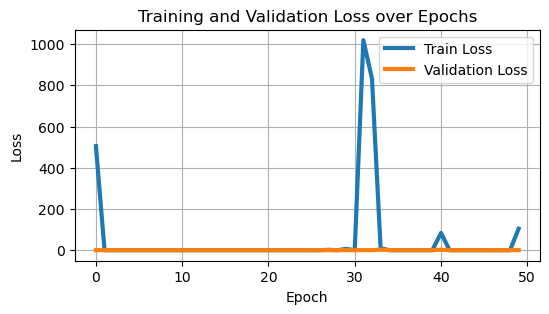

Model Number: 8
Learning Rate: 0.06513594792270827
Weight Decay: 0.00016289762118042547
Epoch 1/50, Train Loss: 148.0424, Validation Loss: 1.0104, Train MAE: 1.8858, Validation MAE: 0.8017
Epoch 11/50, Train Loss: 0.5861, Validation Loss: 1.0208, Train MAE: 0.8031, Validation MAE: 0.8065
Epoch 21/50, Train Loss: 0.5832, Validation Loss: 1.0078, Train MAE: 0.8034, Validation MAE: 0.8004
Epoch 31/50, Train Loss: 0.5836, Validation Loss: 1.0087, Train MAE: 0.8035, Validation MAE: 0.7984
Epoch 41/50, Train Loss: 0.8230, Validation Loss: 1.0391, Train MAE: 0.8734, Validation MAE: 0.8260
Test MAE: 0.8069
Test RMSE: 1.0067
Elapsed time: 250.94299840927124


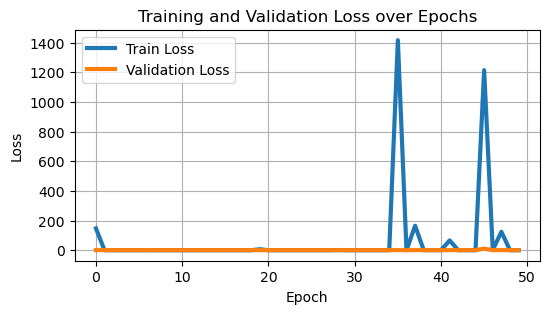

Model Number: 9
Learning Rate: 0.06513594792270827
Weight Decay: 0.00010287010923164324
Epoch 1/50, Train Loss: 302.5585, Validation Loss: 1.0749, Train MAE: 2.4768, Validation MAE: 0.7875
Epoch 11/50, Train Loss: 0.6155, Validation Loss: 1.0285, Train MAE: 0.8216, Validation MAE: 0.7921
Epoch 21/50, Train Loss: 0.5848, Validation Loss: 1.0081, Train MAE: 0.8038, Validation MAE: 0.7991
Epoch 31/50, Train Loss: 2.1178, Validation Loss: 1.0079, Train MAE: 0.8748, Validation MAE: 0.7993
Epoch 41/50, Train Loss: 0.5907, Validation Loss: 1.0156, Train MAE: 0.8045, Validation MAE: 0.8051
Test MAE: 0.9050
Test RMSE: 1.0917
Elapsed time: 251.65900087356567


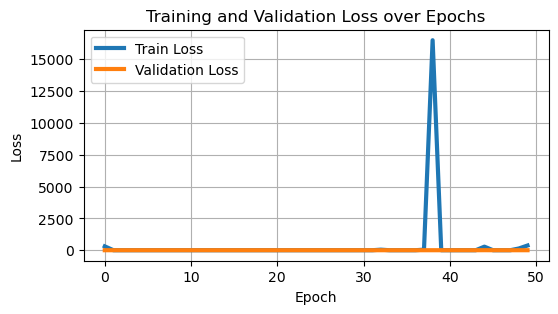

Model Number: 10
Learning Rate: 0.006127970666483626
Weight Decay: 0.00014872540206663904
Epoch 1/50, Train Loss: 6.6490, Validation Loss: 1.1363, Train MAE: 1.2087, Validation MAE: 0.8018
Epoch 11/50, Train Loss: 0.6016, Validation Loss: 1.0191, Train MAE: 0.8116, Validation MAE: 0.8077
Epoch 21/50, Train Loss: 0.5912, Validation Loss: 1.0955, Train MAE: 0.8060, Validation MAE: 0.7838
Epoch 31/50, Train Loss: 0.5877, Validation Loss: 1.0078, Train MAE: 0.8047, Validation MAE: 0.8002
Epoch 41/50, Train Loss: 0.5832, Validation Loss: 1.0092, Train MAE: 0.8035, Validation MAE: 0.7980
Test MAE: 0.8065
Test RMSE: 1.0067
Elapsed time: 251.51600003242493


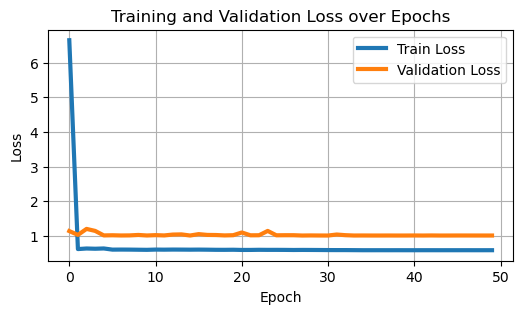

Model Number: 11
Learning Rate: 0.006127970666483626
Weight Decay: 0.00016289762118042547
Epoch 1/50, Train Loss: 5.8477, Validation Loss: 1.0153, Train MAE: 1.1852, Validation MAE: 0.8033
Epoch 11/50, Train Loss: 0.6008, Validation Loss: 1.2292, Train MAE: 0.8113, Validation MAE: 0.8224
Epoch 21/50, Train Loss: 0.5961, Validation Loss: 1.0081, Train MAE: 0.8077, Validation MAE: 0.8006
Epoch 31/50, Train Loss: 0.5886, Validation Loss: 1.0111, Train MAE: 0.8059, Validation MAE: 0.7969
Epoch 41/50, Train Loss: 0.5835, Validation Loss: 1.0078, Train MAE: 0.8038, Validation MAE: 0.8006
Test MAE: 0.8066
Test RMSE: 1.0067
Elapsed time: 250.96602272987366


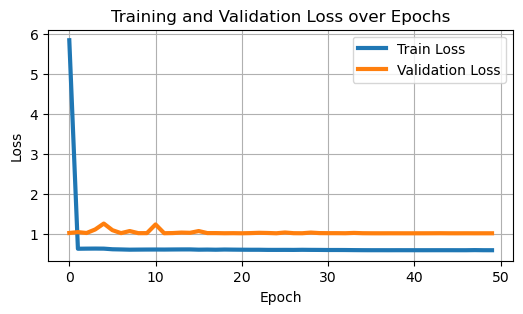

Model Number: 12
Learning Rate: 0.006127970666483626
Weight Decay: 0.00010287010923164324
Epoch 1/50, Train Loss: 5.1498, Validation Loss: 1.0452, Train MAE: 1.1893, Validation MAE: 0.7985
Epoch 11/50, Train Loss: 0.6027, Validation Loss: 1.0649, Train MAE: 0.8121, Validation MAE: 0.8445
Epoch 21/50, Train Loss: 0.5938, Validation Loss: 1.0116, Train MAE: 0.8071, Validation MAE: 0.8035
Epoch 31/50, Train Loss: 0.5892, Validation Loss: 1.0289, Train MAE: 0.8058, Validation MAE: 0.7920
Epoch 41/50, Train Loss: 0.5836, Validation Loss: 1.0079, Train MAE: 0.8036, Validation MAE: 0.8008
Test MAE: 0.8077
Test RMSE: 1.0067
Elapsed time: 250.841002702713


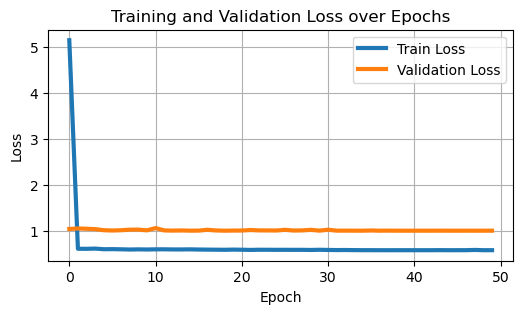

In [39]:
results = pd.DataFrame(columns=[
    "model_no", "model_type", "learning_rate", "weight_decay",
    "validation_mae", "validation_loss", "train_mae", "train_loss", "test_mae"
])

model_no = 1
for lr in lr_list:
    for weight_decay in weight_decay_list:
        print(f"Model Number: {model_no}")
        print(f"Learning Rate: {lr}")
        print(f"Weight Decay: {weight_decay}")

        model = Basic_Model(input_size)
        validation_mae, validation_loss, train_mae, train_loss, test_mae = train_and_evaluate(
            model, df, learning_rate=lr, weight_decay=weight_decay
        )
        
        results = pd.concat([results, pd.DataFrame({
            "model_no": model_no,
            "model_type": "Basic",
            "learning_rate": lr,
            "weight_decay": weight_decay,
            "validation_mae": validation_mae[-1],
            "validation_loss": validation_loss[-1],
            "train_mae": train_mae[-1],
            "train_loss": train_loss[-1],
            "test_mae": test_mae
        }, index=[0])], ignore_index=True)
        
        model_no += 1


### Complex Model

Model Number: 13
Learning Rate: 0.06031190279803947
Weight Decay: 0.00014872540206663904
Dropout: 0.4097645350696537
Epoch 1/50, Train Loss: 60423.3799, Validation Loss: 15.0919, Train MAE: 17.0397, Validation MAE: 3.6668
Epoch 11/50, Train Loss: 0.7921, Validation Loss: 1.0081, Train MAE: 0.8076, Validation MAE: 0.8003
Epoch 21/50, Train Loss: 8.6814, Validation Loss: 1.0110, Train MAE: 0.8206, Validation MAE: 0.7973
Epoch 31/50, Train Loss: 5.1228, Validation Loss: 7.3235, Train MAE: 2.8004, Validation MAE: 2.5131
Epoch 41/50, Train Loss: 3.6398, Validation Loss: 5.0111, Train MAE: 2.2962, Validation MAE: 2.0008
Test MAE: 1.7797
Test RMSE: 2.0447
Elapsed time: 257.4985294342041


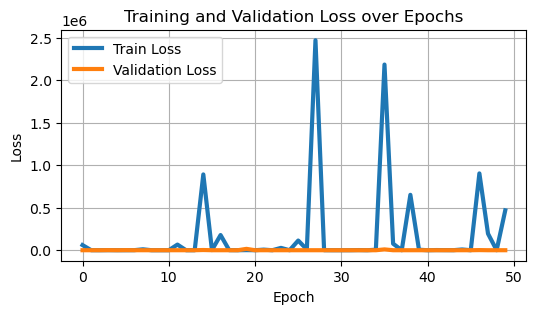

Model Number: 14
Learning Rate: 0.06031190279803947
Weight Decay: 0.00016289762118042547
Dropout: 0.4097645350696537
Epoch 1/50, Train Loss: 26381.8991, Validation Loss: 15.5851, Train MAE: 12.0737, Validation MAE: 2.8961
Epoch 11/50, Train Loss: 0.5834, Validation Loss: 1.0078, Train MAE: 0.8035, Validation MAE: 0.7998
Epoch 21/50, Train Loss: 5.3266, Validation Loss: 1.0078, Train MAE: 0.8225, Validation MAE: 0.8003
Epoch 31/50, Train Loss: 7561.0106, Validation Loss: 4.1127, Train MAE: 3.9901, Validation MAE: 1.8392
Epoch 41/50, Train Loss: 1.6313, Validation Loss: 2.2668, Train MAE: 1.4917, Validation MAE: 1.3177
Test MAE: 3.8708
Test RMSE: 3.9996
Elapsed time: 252.12000060081482


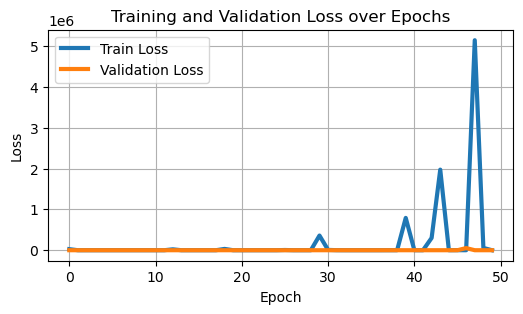

Model Number: 15
Learning Rate: 0.06031190279803947
Weight Decay: 0.00010287010923164324
Dropout: 0.4097645350696537
Epoch 1/50, Train Loss: 3657.5315, Validation Loss: 14.4893, Train MAE: 7.1306, Validation MAE: 2.4218
Epoch 11/50, Train Loss: 0.5853, Validation Loss: 1.0079, Train MAE: 0.8034, Validation MAE: 0.7995
Epoch 21/50, Train Loss: 0.5838, Validation Loss: 1.0080, Train MAE: 0.8032, Validation MAE: 0.8010
Epoch 31/50, Train Loss: 0.6357, Validation Loss: 1.0088, Train MAE: 0.8052, Validation MAE: 0.7983
Epoch 41/50, Train Loss: 0.6027, Validation Loss: 1.0079, Train MAE: 0.8254, Validation MAE: 0.7995
Test MAE: 3.0086
Test RMSE: 3.1726
Elapsed time: 253.84900069236755


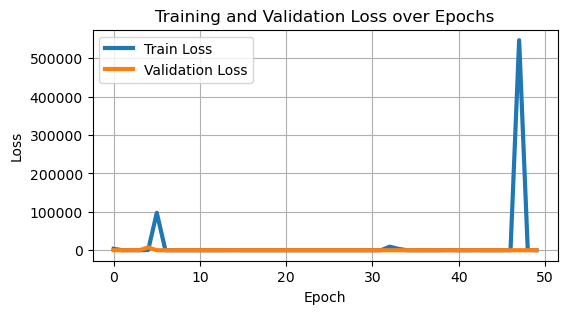

Model Number: 16
Learning Rate: 0.019423344365243327
Weight Decay: 0.00014872540206663904
Dropout: 0.4097645350696537
Epoch 1/50, Train Loss: 37.3518, Validation Loss: 1.5454, Train MAE: 1.9067, Validation MAE: 0.9835
Epoch 11/50, Train Loss: 0.5841, Validation Loss: 1.0080, Train MAE: 0.8037, Validation MAE: 0.7994
Epoch 21/50, Train Loss: 0.5839, Validation Loss: 1.0120, Train MAE: 0.8035, Validation MAE: 0.7965
Epoch 31/50, Train Loss: 7.4992, Validation Loss: 1.0085, Train MAE: 0.9947, Validation MAE: 0.8016
Epoch 41/50, Train Loss: 0.6068, Validation Loss: 1.0192, Train MAE: 0.7903, Validation MAE: 0.7941
Test MAE: 0.9183
Test RMSE: 1.1095
Elapsed time: 257.2609965801239


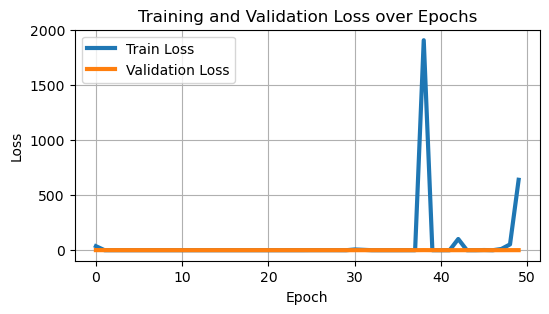

Model Number: 17
Learning Rate: 0.019423344365243327
Weight Decay: 0.00016289762118042547
Dropout: 0.4097645350696537
Epoch 1/50, Train Loss: 256.7536, Validation Loss: 3.5807, Train MAE: 3.2242, Validation MAE: 1.5920
Epoch 11/50, Train Loss: 0.5835, Validation Loss: 1.0088, Train MAE: 0.8036, Validation MAE: 0.7984
Epoch 21/50, Train Loss: 0.5840, Validation Loss: 1.0081, Train MAE: 0.8036, Validation MAE: 0.8012
Epoch 31/50, Train Loss: 0.5852, Validation Loss: 1.0126, Train MAE: 0.8038, Validation MAE: 0.7962
Epoch 41/50, Train Loss: 0.5835, Validation Loss: 1.0078, Train MAE: 0.8035, Validation MAE: 0.7999
Test MAE: 0.8084
Test RMSE: 1.0070
Elapsed time: 257.4620008468628


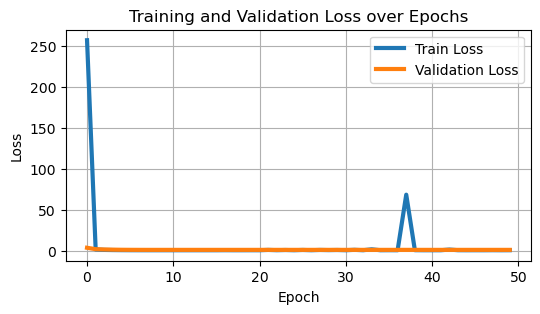

Model Number: 18
Learning Rate: 0.019423344365243327
Weight Decay: 0.00010287010923164324
Dropout: 0.4097645350696537
Epoch 1/50, Train Loss: 396.7797, Validation Loss: 3.6652, Train MAE: 2.9274, Validation MAE: 1.5737
Epoch 11/50, Train Loss: 0.5857, Validation Loss: 1.0089, Train MAE: 0.8045, Validation MAE: 0.8011
Epoch 21/50, Train Loss: 0.5837, Validation Loss: 1.0079, Train MAE: 0.8034, Validation MAE: 0.7995
Epoch 31/50, Train Loss: 43.7033, Validation Loss: 1.1048, Train MAE: 1.0224, Validation MAE: 0.7827
Epoch 41/50, Train Loss: 10.7584, Validation Loss: 1.0080, Train MAE: 0.8358, Validation MAE: 0.7992
Test MAE: 0.8062
Test RMSE: 1.0068
Elapsed time: 256.8479986190796


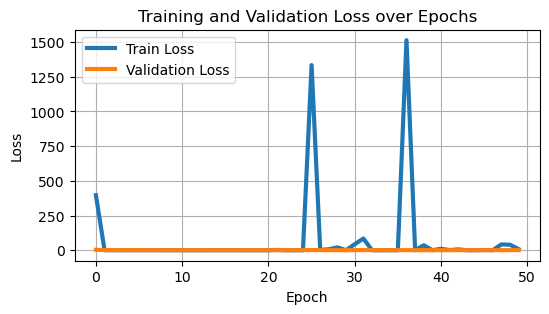

Model Number: 19
Learning Rate: 0.06513594792270827
Weight Decay: 0.00014872540206663904
Dropout: 0.4097645350696537
Epoch 1/50, Train Loss: 19298.6028, Validation Loss: 5.4057, Train MAE: 14.8762, Validation MAE: 1.9306
Epoch 11/50, Train Loss: 0.6966, Validation Loss: 1.0100, Train MAE: 0.8130, Validation MAE: 0.7986
Epoch 21/50, Train Loss: 2.2527, Validation Loss: 1.0113, Train MAE: 0.8429, Validation MAE: 0.7994
Epoch 31/50, Train Loss: 609193.3201, Validation Loss: 1.0604, Train MAE: 12.3393, Validation MAE: 0.8425
Epoch 41/50, Train Loss: 0.5882, Validation Loss: 1.0092, Train MAE: 0.8096, Validation MAE: 0.8023
Test MAE: 4.0014
Test RMSE: 4.1261
Elapsed time: 255.60800004005432


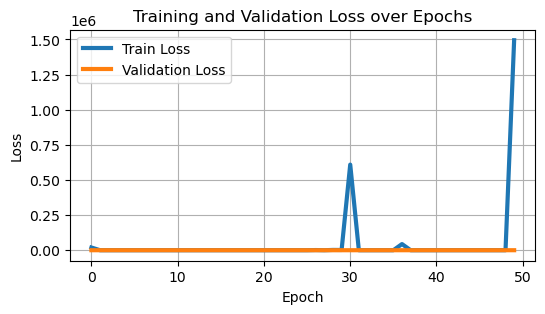

Model Number: 20
Learning Rate: 0.06513594792270827
Weight Decay: 0.00016289762118042547
Dropout: 0.4097645350696537
Epoch 1/50, Train Loss: 2491.6825, Validation Loss: 1.9087, Train MAE: 5.8307, Validation MAE: 1.1082
Epoch 11/50, Train Loss: 0.5833, Validation Loss: 1.0078, Train MAE: 0.8033, Validation MAE: 0.7996
Epoch 21/50, Train Loss: 0.6704, Validation Loss: 1.0751, Train MAE: 0.8116, Validation MAE: 0.8050
Epoch 31/50, Train Loss: 0.9464, Validation Loss: 1.7486, Train MAE: 1.0137, Validation MAE: 0.9528
Epoch 41/50, Train Loss: 0.5969, Validation Loss: 1.0079, Train MAE: 0.8043, Validation MAE: 0.7994
Test MAE: 0.7956
Test RMSE: 1.0312
Elapsed time: 256.92400097846985


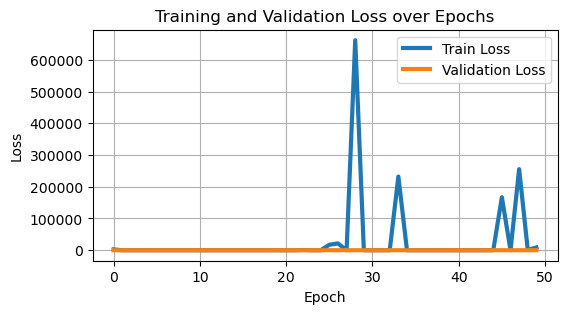

Model Number: 21
Learning Rate: 0.06513594792270827
Weight Decay: 0.00010287010923164324
Dropout: 0.4097645350696537
Epoch 1/50, Train Loss: 2942.1655, Validation Loss: 4.9091, Train MAE: 7.0488, Validation MAE: 1.9062
Epoch 11/50, Train Loss: 0.5833, Validation Loss: 1.0078, Train MAE: 0.8035, Validation MAE: 0.7999
Epoch 21/50, Train Loss: 1.2303, Validation Loss: 1.0360, Train MAE: 0.8505, Validation MAE: 0.8230
Epoch 31/50, Train Loss: 72478.5466, Validation Loss: 1926498.1250, Train MAE: 6.7998, Validation MAE: 54.6707
Epoch 41/50, Train Loss: 2.7975, Validation Loss: 4.5624, Train MAE: 1.9486, Validation MAE: 1.8854
Test MAE: 0.8048
Test RMSE: 1.0077
Elapsed time: 258.74600195884705


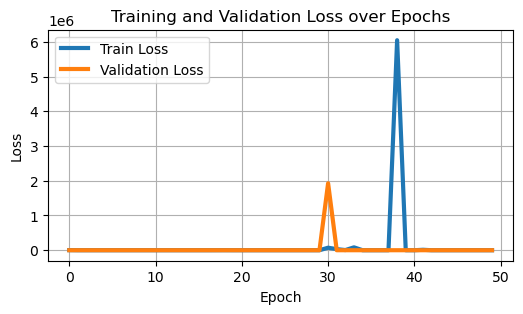

Model Number: 22
Learning Rate: 0.006127970666483626
Weight Decay: 0.00014872540206663904
Dropout: 0.4097645350696537
Epoch 1/50, Train Loss: 7.5125, Validation Loss: 1.9181, Train MAE: 1.5006, Validation MAE: 1.1061
Epoch 11/50, Train Loss: 0.5834, Validation Loss: 1.0078, Train MAE: 0.8033, Validation MAE: 0.8005
Epoch 21/50, Train Loss: 0.5837, Validation Loss: 1.0081, Train MAE: 0.8035, Validation MAE: 0.7990
Epoch 31/50, Train Loss: 0.5836, Validation Loss: 1.0082, Train MAE: 0.8039, Validation MAE: 0.7989
Epoch 41/50, Train Loss: 0.5844, Validation Loss: 1.0080, Train MAE: 0.8042, Validation MAE: 0.7992
Test MAE: 0.8060
Test RMSE: 1.0069
Elapsed time: 262.69599986076355


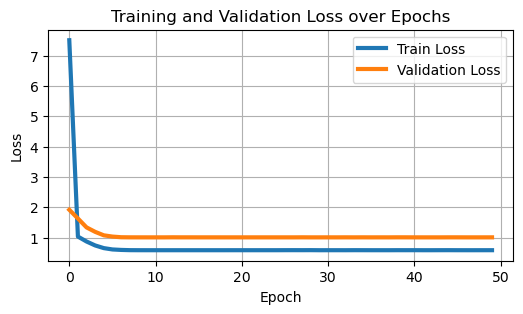

Model Number: 23
Learning Rate: 0.006127970666483626
Weight Decay: 0.00016289762118042547
Dropout: 0.4097645350696537
Epoch 1/50, Train Loss: 11.3863, Validation Loss: 2.1684, Train MAE: 1.5992, Validation MAE: 1.1691
Epoch 11/50, Train Loss: 0.5837, Validation Loss: 1.0119, Train MAE: 0.8037, Validation MAE: 0.7968
Epoch 21/50, Train Loss: 0.5833, Validation Loss: 1.0081, Train MAE: 0.8034, Validation MAE: 0.7990
Epoch 31/50, Train Loss: 0.5833, Validation Loss: 1.0093, Train MAE: 0.8036, Validation MAE: 0.7979
Epoch 41/50, Train Loss: 0.5838, Validation Loss: 1.0082, Train MAE: 0.8035, Validation MAE: 0.7989
Test MAE: 0.8075
Test RMSE: 1.0067
Elapsed time: 263.06999945640564


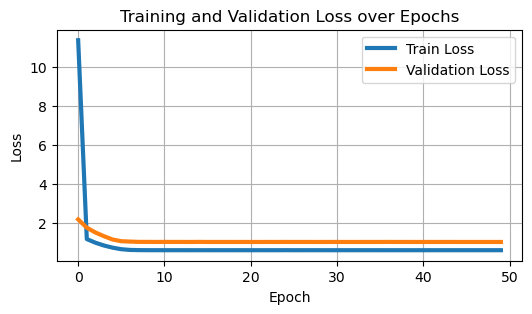

Model Number: 24
Learning Rate: 0.006127970666483626
Weight Decay: 0.00010287010923164324
Dropout: 0.4097645350696537
Epoch 1/50, Train Loss: 3.8868, Validation Loss: 1.9324, Train MAE: 1.4185, Validation MAE: 1.1041
Epoch 11/50, Train Loss: 0.5833, Validation Loss: 1.0106, Train MAE: 0.8034, Validation MAE: 0.7971
Epoch 21/50, Train Loss: 0.5834, Validation Loss: 1.0079, Train MAE: 0.8034, Validation MAE: 0.7995
Epoch 31/50, Train Loss: 0.5835, Validation Loss: 1.0078, Train MAE: 0.8035, Validation MAE: 0.8006
Epoch 41/50, Train Loss: 0.5833, Validation Loss: 1.0080, Train MAE: 0.8034, Validation MAE: 0.7992
Test MAE: 0.8080
Test RMSE: 1.0068
Elapsed time: 262.2410206794739


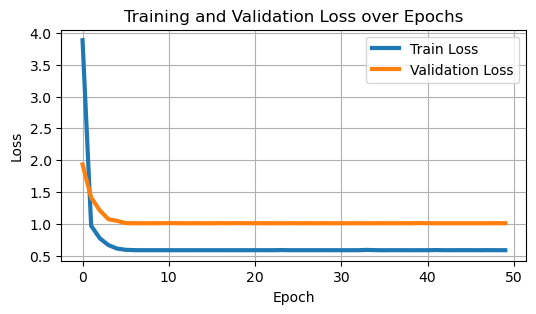

Model Number: 25
Learning Rate: 0.06031190279803947
Weight Decay: 0.00014872540206663904
Dropout: 0.409787480281387
Epoch 1/50, Train Loss: 60176.9682, Validation Loss: 13.9893, Train MAE: 16.8026, Validation MAE: 3.5945
Epoch 11/50, Train Loss: 0.5832, Validation Loss: 1.0078, Train MAE: 0.8034, Validation MAE: 0.7997
Epoch 21/50, Train Loss: 517.4522, Validation Loss: 1.0814, Train MAE: 1.0746, Validation MAE: 0.8558
Epoch 31/50, Train Loss: 1.3992, Validation Loss: 1.0143, Train MAE: 0.8271, Validation MAE: 0.7956
Epoch 41/50, Train Loss: 0.5833, Validation Loss: 1.0082, Train MAE: 0.8035, Validation MAE: 0.7989
Test MAE: 0.7884
Test RMSE: 1.0711
Elapsed time: 260.877001285553


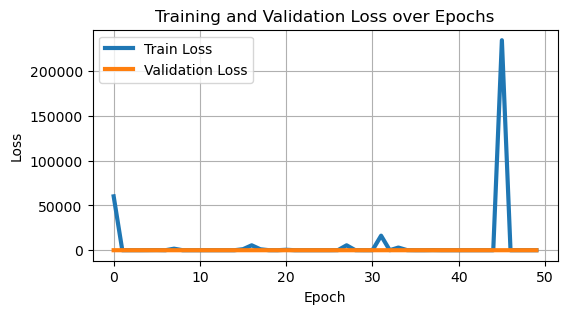

Model Number: 26
Learning Rate: 0.06031190279803947
Weight Decay: 0.00016289762118042547
Dropout: 0.409787480281387
Epoch 1/50, Train Loss: 7539.8284, Validation Loss: 98.1131, Train MAE: 9.9443, Validation MAE: 2.6254
Epoch 11/50, Train Loss: 61892.2098, Validation Loss: 4.6295, Train MAE: 4.1239, Validation MAE: 1.7517
Epoch 21/50, Train Loss: 919039.9746, Validation Loss: 596.1509, Train MAE: 34.6846, Validation MAE: 3.7467
Epoch 31/50, Train Loss: 0.5845, Validation Loss: 1.0083, Train MAE: 0.8003, Validation MAE: 0.7988
Epoch 41/50, Train Loss: 29364.1857, Validation Loss: 1.0478, Train MAE: 8.8318, Validation MAE: 0.7993
Test MAE: 0.8022
Test RMSE: 1.0110
Elapsed time: 262.7560787200928


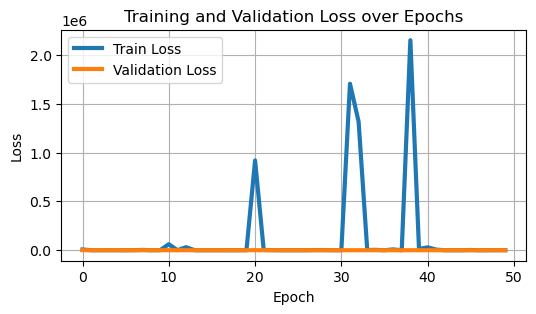

Model Number: 27
Learning Rate: 0.06031190279803947
Weight Decay: 0.00010287010923164324
Dropout: 0.409787480281387
Epoch 1/50, Train Loss: 7405.4610, Validation Loss: 8.3496, Train MAE: 8.9555, Validation MAE: 1.8185
Epoch 11/50, Train Loss: 0.5835, Validation Loss: 1.0078, Train MAE: 0.8034, Validation MAE: 0.8000
Epoch 21/50, Train Loss: 1.8064, Validation Loss: 1.0078, Train MAE: 0.8276, Validation MAE: 0.8002
Epoch 31/50, Train Loss: 2.3391, Validation Loss: 2.4612, Train MAE: 1.8106, Validation MAE: 1.3835
Epoch 41/50, Train Loss: 1998.8392, Validation Loss: 1.8236, Train MAE: 1.9409, Validation MAE: 1.0481
Test MAE: 1.4353
Test RMSE: 1.6252
Elapsed time: 264.2760012149811


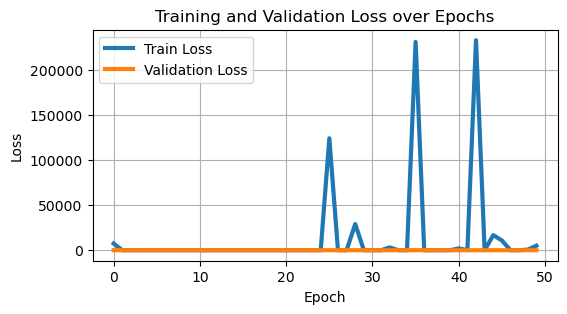

Model Number: 28
Learning Rate: 0.019423344365243327
Weight Decay: 0.00014872540206663904
Dropout: 0.409787480281387
Epoch 1/50, Train Loss: 73.7791, Validation Loss: 2.8478, Train MAE: 2.1896, Validation MAE: 1.3718
Epoch 11/50, Train Loss: 0.6194, Validation Loss: 1.0955, Train MAE: 0.8048, Validation MAE: 0.8028
Epoch 21/50, Train Loss: 153.9314, Validation Loss: 155.0075, Train MAE: 1.3588, Validation MAE: 1.1049
Epoch 31/50, Train Loss: 31.9377, Validation Loss: 1.0085, Train MAE: 0.8433, Validation MAE: 0.7998
Epoch 41/50, Train Loss: 0.5833, Validation Loss: 1.0077, Train MAE: 0.8036, Validation MAE: 0.8001
Test MAE: 0.8066
Test RMSE: 1.0067
Elapsed time: 266.4205102920532


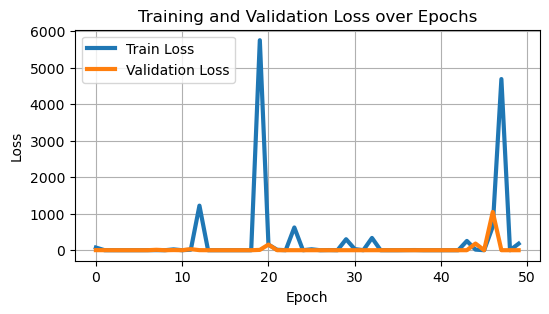

Model Number: 29
Learning Rate: 0.019423344365243327
Weight Decay: 0.00016289762118042547
Dropout: 0.409787480281387
Epoch 1/50, Train Loss: 218.2309, Validation Loss: 3.5877, Train MAE: 2.5930, Validation MAE: 1.5856
Epoch 11/50, Train Loss: 0.5842, Validation Loss: 1.0088, Train MAE: 0.8038, Validation MAE: 0.7988
Epoch 21/50, Train Loss: 0.5833, Validation Loss: 1.0078, Train MAE: 0.8035, Validation MAE: 0.8005
Epoch 31/50, Train Loss: 1.7804, Validation Loss: 1.0109, Train MAE: 0.8284, Validation MAE: 0.7970
Epoch 41/50, Train Loss: 0.5833, Validation Loss: 1.0089, Train MAE: 0.8036, Validation MAE: 0.7982
Test MAE: 0.8069
Test RMSE: 1.0067
Elapsed time: 268.1177866458893


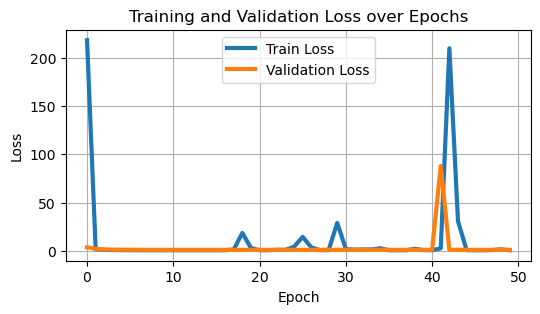

Model Number: 30
Learning Rate: 0.019423344365243327
Weight Decay: 0.00010287010923164324
Dropout: 0.409787480281387
Epoch 1/50, Train Loss: 18.1380, Validation Loss: 2.1484, Train MAE: 1.9319, Validation MAE: 1.1987
Epoch 11/50, Train Loss: 0.5838, Validation Loss: 1.0082, Train MAE: 0.8035, Validation MAE: 0.7990
Epoch 21/50, Train Loss: 0.5839, Validation Loss: 1.0078, Train MAE: 0.8034, Validation MAE: 0.8006
Epoch 31/50, Train Loss: 55.3744, Validation Loss: 1.0100, Train MAE: 1.2267, Validation MAE: 0.8027
Epoch 41/50, Train Loss: 0.5833, Validation Loss: 1.0079, Train MAE: 0.8033, Validation MAE: 0.8008
Test MAE: 0.7949
Test RMSE: 1.0342
Elapsed time: 266.905588388443


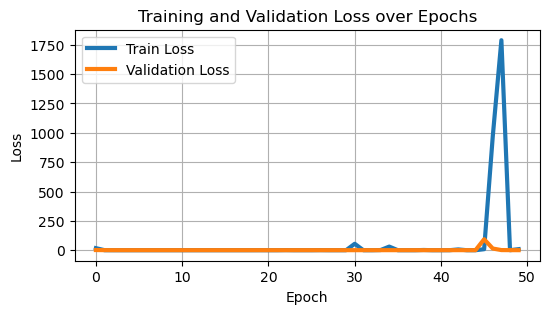

Model Number: 31
Learning Rate: 0.06513594792270827
Weight Decay: 0.00014872540206663904
Dropout: 0.409787480281387
Epoch 1/50, Train Loss: 58994.1742, Validation Loss: 13.6387, Train MAE: 18.9032, Validation MAE: 3.5523
Epoch 11/50, Train Loss: 0.5831, Validation Loss: 1.0078, Train MAE: 0.8034, Validation MAE: 0.7997
Epoch 21/50, Train Loss: 758893.3197, Validation Loss: 3.1145, Train MAE: 16.5097, Validation MAE: 1.5755
Epoch 31/50, Train Loss: 0.6052, Validation Loss: 1.0206, Train MAE: 0.7910, Validation MAE: 0.7938
Epoch 41/50, Train Loss: 4214.8463, Validation Loss: 2.3374, Train MAE: 2.7813, Validation MAE: 1.2230
Test MAE: 0.8026
Test RMSE: 1.0105
Elapsed time: 267.0569372177124


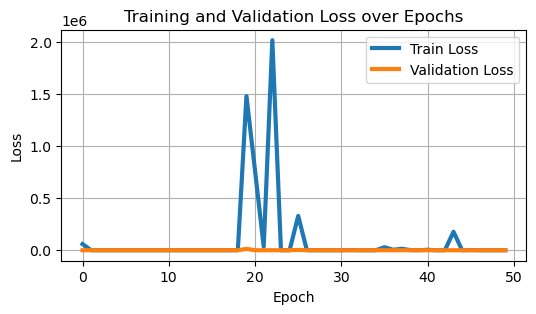

Model Number: 32
Learning Rate: 0.06513594792270827
Weight Decay: 0.00016289762118042547
Dropout: 0.409787480281387
Epoch 1/50, Train Loss: 158754.4725, Validation Loss: 19.1235, Train MAE: 24.5888, Validation MAE: 3.7253
Epoch 11/50, Train Loss: 0.6707, Validation Loss: 1.0078, Train MAE: 0.8057, Validation MAE: 0.7998
Epoch 21/50, Train Loss: 10.6341, Validation Loss: 1.7456, Train MAE: 1.1782, Validation MAE: 1.0713
Epoch 31/50, Train Loss: 19.3467, Validation Loss: 1.3319, Train MAE: 0.9819, Validation MAE: 0.8262
Epoch 41/50, Train Loss: 19424.9734, Validation Loss: 1.4128, Train MAE: 3.4974, Validation MAE: 0.9790
Test MAE: 3.8813
Test RMSE: 4.0098
Elapsed time: 268.3028130531311


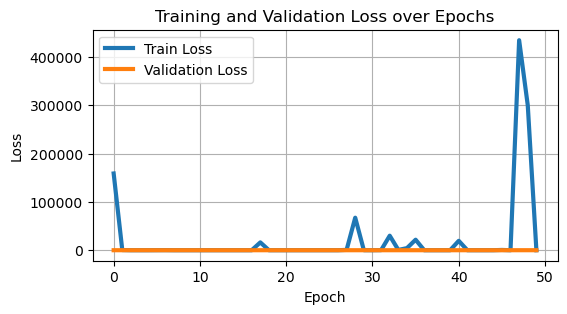

Model Number: 33
Learning Rate: 0.06513594792270827
Weight Decay: 0.00010287010923164324
Dropout: 0.409787480281387
Epoch 1/50, Train Loss: 75654.2777, Validation Loss: 13.4917, Train MAE: 19.1631, Validation MAE: 3.5333
Epoch 11/50, Train Loss: 0.6164, Validation Loss: 1.0079, Train MAE: 0.8043, Validation MAE: 0.7994
Epoch 21/50, Train Loss: 96.4349, Validation Loss: 1.0129, Train MAE: 0.9933, Validation MAE: 0.7979
Epoch 31/50, Train Loss: 1.9722, Validation Loss: 1.7696, Train MAE: 1.3315, Validation MAE: 1.0297
Epoch 41/50, Train Loss: 99592.8132, Validation Loss: 4.4697, Train MAE: 8.7347, Validation MAE: 1.9285
Test MAE: 4.7120
Test RMSE: 4.8183
Elapsed time: 268.33227276802063


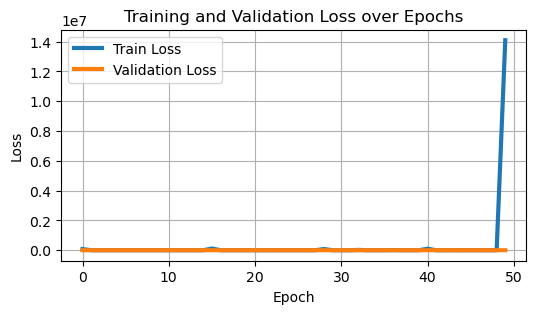

Model Number: 34
Learning Rate: 0.006127970666483626
Weight Decay: 0.00014872540206663904
Dropout: 0.409787480281387
Epoch 1/50, Train Loss: 9.0337, Validation Loss: 2.0286, Train MAE: 1.5937, Validation MAE: 1.1497
Epoch 11/50, Train Loss: 0.5840, Validation Loss: 1.0089, Train MAE: 0.8039, Validation MAE: 0.8017
Epoch 21/50, Train Loss: 0.5834, Validation Loss: 1.0081, Train MAE: 0.8034, Validation MAE: 0.8011
Epoch 31/50, Train Loss: 0.5834, Validation Loss: 1.0085, Train MAE: 0.8034, Validation MAE: 0.7986
Epoch 41/50, Train Loss: 0.5836, Validation Loss: 1.0089, Train MAE: 0.8038, Validation MAE: 0.7982
Test MAE: 0.8087
Test RMSE: 1.0072
Elapsed time: 269.04945731163025


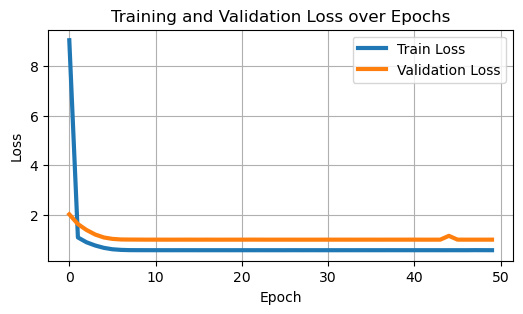

Model Number: 35
Learning Rate: 0.006127970666483626
Weight Decay: 0.00016289762118042547
Dropout: 0.409787480281387
Epoch 1/50, Train Loss: 8.5675, Validation Loss: 2.1191, Train MAE: 1.6372, Validation MAE: 1.1818
Epoch 11/50, Train Loss: 0.5833, Validation Loss: 1.0079, Train MAE: 0.8032, Validation MAE: 0.8007
Epoch 21/50, Train Loss: 0.5834, Validation Loss: 1.0079, Train MAE: 0.8034, Validation MAE: 0.8007
Epoch 31/50, Train Loss: 0.5836, Validation Loss: 1.0078, Train MAE: 0.8035, Validation MAE: 0.8003
Epoch 41/50, Train Loss: 0.5833, Validation Loss: 1.0083, Train MAE: 0.8035, Validation MAE: 0.7988
Test MAE: 0.8078
Test RMSE: 1.0068
Elapsed time: 268.61738753318787


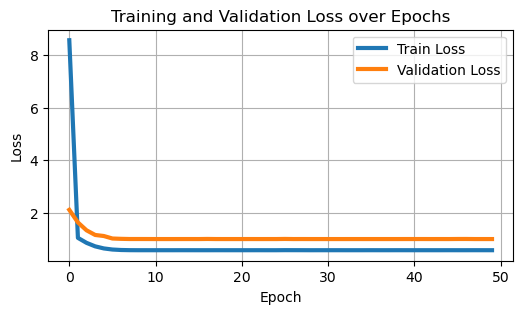

Model Number: 36
Learning Rate: 0.006127970666483626
Weight Decay: 0.00010287010923164324
Dropout: 0.409787480281387
Epoch 1/50, Train Loss: 8.7934, Validation Loss: 2.0256, Train MAE: 1.5832, Validation MAE: 1.1371
Epoch 11/50, Train Loss: 0.5835, Validation Loss: 1.0079, Train MAE: 0.8036, Validation MAE: 0.7994
Epoch 21/50, Train Loss: 0.5836, Validation Loss: 1.0098, Train MAE: 0.8033, Validation MAE: 0.7976
Epoch 31/50, Train Loss: 0.5834, Validation Loss: 1.0083, Train MAE: 0.8036, Validation MAE: 0.7988
Epoch 41/50, Train Loss: 0.5835, Validation Loss: 1.0079, Train MAE: 0.8036, Validation MAE: 0.8008
Test MAE: 0.8084
Test RMSE: 1.0070
Elapsed time: 269.89522075653076


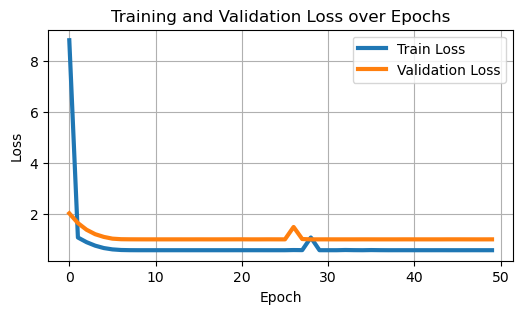

Model Number: 37
Learning Rate: 0.06031190279803947
Weight Decay: 0.00014872540206663904
Dropout: 0.43406564476603504
Epoch 1/50, Train Loss: 3378.4654, Validation Loss: 1.9220, Train MAE: 7.1786, Validation MAE: 1.1094
Epoch 11/50, Train Loss: 0.5833, Validation Loss: 1.0078, Train MAE: 0.8036, Validation MAE: 0.8000
Epoch 21/50, Train Loss: 1.1857, Validation Loss: 1.0087, Train MAE: 0.8346, Validation MAE: 0.8018
Epoch 31/50, Train Loss: 2.5050, Validation Loss: 1.0086, Train MAE: 0.8695, Validation MAE: 0.7985
Epoch 41/50, Train Loss: 0.5971, Validation Loss: 1.0085, Train MAE: 0.8043, Validation MAE: 0.7985
Test MAE: 1.3724
Test RMSE: 1.5634
Elapsed time: 269.3339033126831


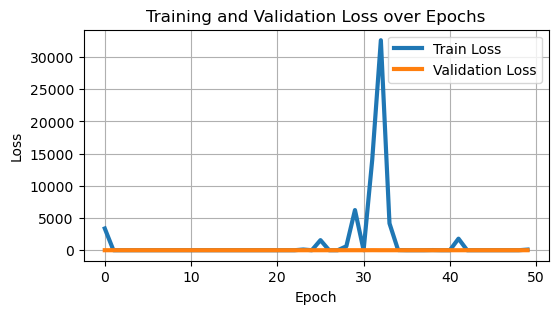

Model Number: 38
Learning Rate: 0.06031190279803947
Weight Decay: 0.00016289762118042547
Dropout: 0.43406564476603504
Epoch 1/50, Train Loss: 24033.4343, Validation Loss: 11.8210, Train MAE: 14.1563, Validation MAE: 3.2881
Epoch 11/50, Train Loss: 0.5834, Validation Loss: 1.0086, Train MAE: 0.8037, Validation MAE: 0.7993
Epoch 21/50, Train Loss: 0.5842, Validation Loss: 1.0079, Train MAE: 0.8035, Validation MAE: 0.7994
Epoch 31/50, Train Loss: 2188.0728, Validation Loss: 2.9689, Train MAE: 2.1590, Validation MAE: 1.5370
Epoch 41/50, Train Loss: 0.6189, Validation Loss: 1.0210, Train MAE: 0.7905, Validation MAE: 0.7937
Test MAE: 1.1482
Test RMSE: 1.3396
Elapsed time: 267.4089951515198


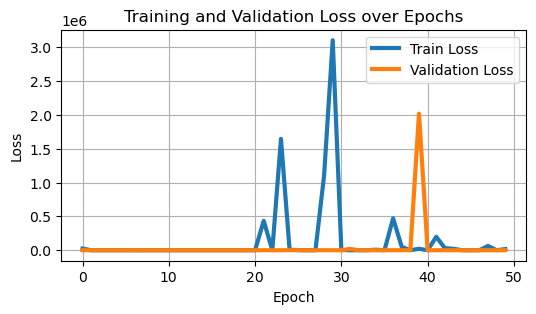

Model Number: 39
Learning Rate: 0.06031190279803947
Weight Decay: 0.00010287010923164324
Dropout: 0.43406564476603504
Epoch 1/50, Train Loss: 1797.7255, Validation Loss: 4.2802, Train MAE: 6.7316, Validation MAE: 1.8724
Epoch 11/50, Train Loss: 0.5839, Validation Loss: 1.0084, Train MAE: 0.8039, Validation MAE: 0.8005
Epoch 21/50, Train Loss: 0.5844, Validation Loss: 1.0125, Train MAE: 0.8035, Validation MAE: 0.8040
Epoch 31/50, Train Loss: 0.6222, Validation Loss: 1.0079, Train MAE: 0.8065, Validation MAE: 0.7993
Epoch 41/50, Train Loss: 0.5835, Validation Loss: 1.0079, Train MAE: 0.8033, Validation MAE: 0.7995
Test MAE: 1.5017
Test RMSE: 1.6920
Elapsed time: 267.64899921417236


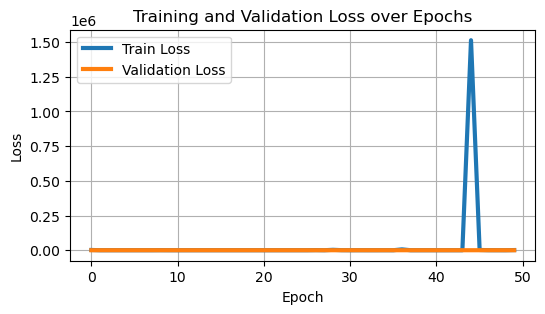

Model Number: 40
Learning Rate: 0.019423344365243327
Weight Decay: 0.00014872540206663904
Dropout: 0.43406564476603504
Epoch 1/50, Train Loss: 83.1728, Validation Loss: 2.7781, Train MAE: 2.4188, Validation MAE: 1.3639
Epoch 11/50, Train Loss: 0.5834, Validation Loss: 1.0078, Train MAE: 0.8034, Validation MAE: 0.8005
Epoch 21/50, Train Loss: 0.6064, Validation Loss: 8.1144, Train MAE: 0.8069, Validation MAE: 0.8284
Epoch 31/50, Train Loss: 0.6123, Validation Loss: 1.0082, Train MAE: 0.8050, Validation MAE: 0.7989
Epoch 41/50, Train Loss: 0.7549, Validation Loss: 5.8306, Train MAE: 0.8108, Validation MAE: 0.8329
Test MAE: 0.8238
Test RMSE: 1.1037
Elapsed time: 267.43200063705444


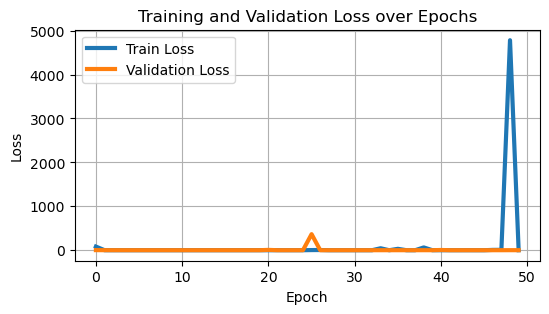

Model Number: 41
Learning Rate: 0.019423344365243327
Weight Decay: 0.00016289762118042547
Dropout: 0.43406564476603504
Epoch 1/50, Train Loss: 246.0860, Validation Loss: 3.2352, Train MAE: 2.4436, Validation MAE: 1.4407
Epoch 11/50, Train Loss: 0.5835, Validation Loss: 1.0080, Train MAE: 0.8037, Validation MAE: 0.8004
Epoch 21/50, Train Loss: 7.7444, Validation Loss: 1.0078, Train MAE: 0.9258, Validation MAE: 0.8005
Epoch 31/50, Train Loss: 0.8877, Validation Loss: 1.0081, Train MAE: 0.8248, Validation MAE: 0.7994
Epoch 41/50, Train Loss: 0.5837, Validation Loss: 1.0083, Train MAE: 0.8036, Validation MAE: 0.8014
Test MAE: 0.8051
Test RMSE: 1.0074
Elapsed time: 267.0800006389618


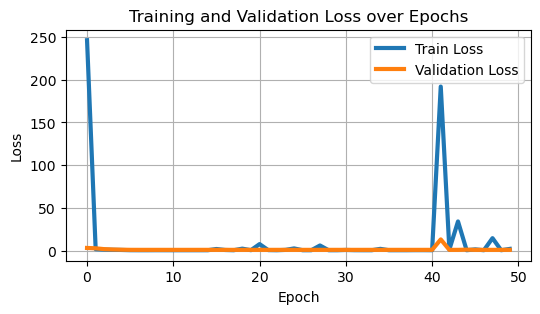

Model Number: 42
Learning Rate: 0.019423344365243327
Weight Decay: 0.00010287010923164324
Dropout: 0.43406564476603504
Epoch 1/50, Train Loss: 290.1802, Validation Loss: 2.9231, Train MAE: 2.6537, Validation MAE: 1.4021
Epoch 11/50, Train Loss: 0.8303, Validation Loss: 1.0097, Train MAE: 0.8123, Validation MAE: 0.8010
Epoch 21/50, Train Loss: 38.1548, Validation Loss: 1.3735, Train MAE: 0.9062, Validation MAE: 0.9611
Epoch 31/50, Train Loss: 0.5834, Validation Loss: 1.0078, Train MAE: 0.8039, Validation MAE: 0.7996
Epoch 41/50, Train Loss: 13.0451, Validation Loss: 1.0118, Train MAE: 0.9106, Validation MAE: 0.7984
Test MAE: 0.8076
Test RMSE: 1.0067
Elapsed time: 267.40051651000977


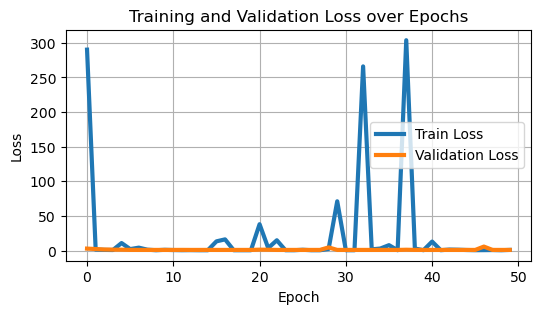

Model Number: 43
Learning Rate: 0.06513594792270827
Weight Decay: 0.00014872540206663904
Dropout: 0.43406564476603504
Epoch 1/50, Train Loss: 133895.1384, Validation Loss: 14.9081, Train MAE: 23.6123, Validation MAE: 3.7283
Epoch 11/50, Train Loss: 0.5868, Validation Loss: 1.0088, Train MAE: 0.8036, Validation MAE: 0.7992
Epoch 21/50, Train Loss: 53718.8164, Validation Loss: 8.2064, Train MAE: 6.8310, Validation MAE: 2.6912
Epoch 31/50, Train Loss: 0.6886, Validation Loss: 1.1460, Train MAE: 0.8043, Validation MAE: 0.7793
Epoch 41/50, Train Loss: 0.6323, Validation Loss: 1.0268, Train MAE: 0.8617, Validation MAE: 0.8136
Test MAE: 0.8096
Test RMSE: 1.0079
Elapsed time: 271.4440007209778


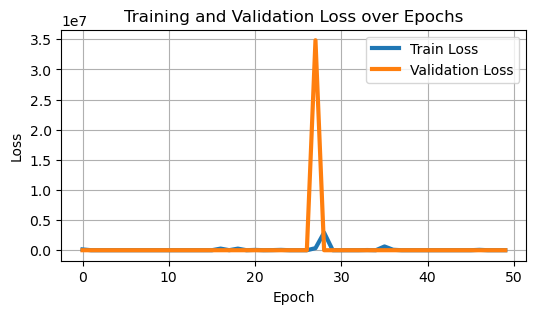

Model Number: 44
Learning Rate: 0.06513594792270827
Weight Decay: 0.00016289762118042547
Dropout: 0.43406564476603504
Epoch 1/50, Train Loss: 64535.7395, Validation Loss: 369.5654, Train MAE: 16.8354, Validation MAE: 3.3970
Epoch 11/50, Train Loss: 14310.1680, Validation Loss: 3.1252, Train MAE: 1.7529, Validation MAE: 1.4048
Epoch 21/50, Train Loss: 1.3673, Validation Loss: 1.0080, Train MAE: 0.8102, Validation MAE: 0.7993
Epoch 31/50, Train Loss: 58388.2768, Validation Loss: 6.0944, Train MAE: 6.1479, Validation MAE: 2.2554
Epoch 41/50, Train Loss: 0.5844, Validation Loss: 1.0078, Train MAE: 0.8053, Validation MAE: 0.7999
Test MAE: 4.9058
Test RMSE: 5.0080
Elapsed time: 266.8180012702942


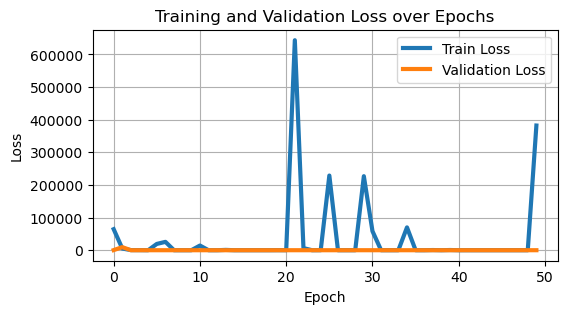

Model Number: 45
Learning Rate: 0.06513594792270827
Weight Decay: 0.00010287010923164324
Dropout: 0.43406564476603504
Epoch 1/50, Train Loss: 38120.1232, Validation Loss: 11.5848, Train MAE: 16.4882, Validation MAE: 3.1995
Epoch 11/50, Train Loss: 0.5834, Validation Loss: 1.0078, Train MAE: 0.8033, Validation MAE: 0.8001
Epoch 21/50, Train Loss: 0.5836, Validation Loss: 1.0085, Train MAE: 0.8036, Validation MAE: 0.7990
Epoch 31/50, Train Loss: 0.6409, Validation Loss: 1.0194, Train MAE: 0.8054, Validation MAE: 0.8020
Epoch 41/50, Train Loss: 0.5833, Validation Loss: 1.0078, Train MAE: 0.8037, Validation MAE: 0.7998
Test MAE: 0.8108
Test RMSE: 1.0094
Elapsed time: 266.4870002269745


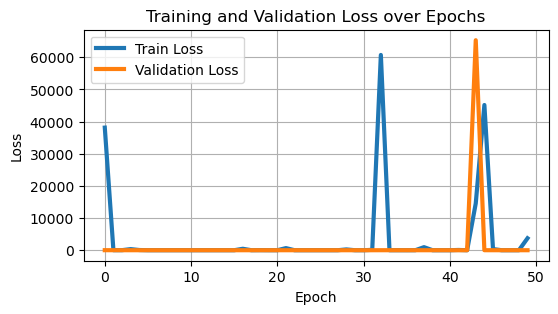

Model Number: 46
Learning Rate: 0.006127970666483626
Weight Decay: 0.00014872540206663904
Dropout: 0.43406564476603504
Epoch 1/50, Train Loss: 15.7303, Validation Loss: 2.1259, Train MAE: 1.7385, Validation MAE: 1.1804
Epoch 11/50, Train Loss: 0.5831, Validation Loss: 1.0084, Train MAE: 0.8036, Validation MAE: 0.7987
Epoch 21/50, Train Loss: 0.5832, Validation Loss: 1.0104, Train MAE: 0.8036, Validation MAE: 0.7973
Epoch 31/50, Train Loss: 0.5841, Validation Loss: 1.0086, Train MAE: 0.8039, Validation MAE: 0.8005
Epoch 41/50, Train Loss: 0.5837, Validation Loss: 1.0078, Train MAE: 0.8035, Validation MAE: 0.8001
Test MAE: 0.8059
Test RMSE: 1.0069
Elapsed time: 266.47699999809265


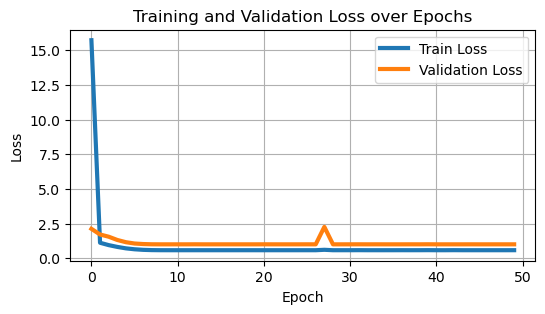

Model Number: 47
Learning Rate: 0.006127970666483626
Weight Decay: 0.00016289762118042547
Dropout: 0.43406564476603504
Epoch 1/50, Train Loss: 8.6823, Validation Loss: 2.1532, Train MAE: 1.6021, Validation MAE: 1.1877
Epoch 11/50, Train Loss: 0.5833, Validation Loss: 1.0081, Train MAE: 0.8035, Validation MAE: 0.7991
Epoch 21/50, Train Loss: 0.5835, Validation Loss: 1.0078, Train MAE: 0.8036, Validation MAE: 0.7999
Epoch 31/50, Train Loss: 0.5844, Validation Loss: 1.0079, Train MAE: 0.8037, Validation MAE: 0.7994
Epoch 41/50, Train Loss: 0.5832, Validation Loss: 1.0078, Train MAE: 0.8034, Validation MAE: 0.7996
Test MAE: 0.8058
Test RMSE: 1.0070
Elapsed time: 269.6052722930908


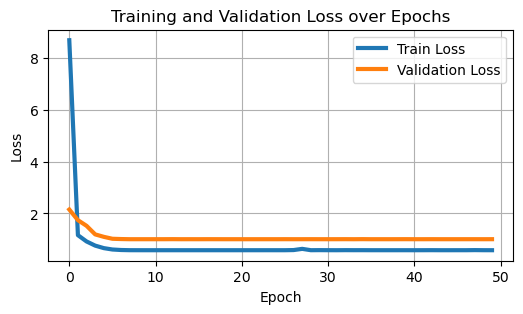

Model Number: 48
Learning Rate: 0.006127970666483626
Weight Decay: 0.00010287010923164324
Dropout: 0.43406564476603504
Epoch 1/50, Train Loss: 4.4772, Validation Loss: 1.9131, Train MAE: 1.5075, Validation MAE: 1.1117
Epoch 11/50, Train Loss: 0.5832, Validation Loss: 1.0080, Train MAE: 0.8034, Validation MAE: 0.8009
Epoch 21/50, Train Loss: 0.5833, Validation Loss: 1.0079, Train MAE: 0.8036, Validation MAE: 0.7995
Epoch 31/50, Train Loss: 0.5834, Validation Loss: 1.0078, Train MAE: 0.8033, Validation MAE: 0.8001
Epoch 41/50, Train Loss: 0.5835, Validation Loss: 1.0078, Train MAE: 0.8036, Validation MAE: 0.8001
Test MAE: 0.8065
Test RMSE: 1.0067
Elapsed time: 270.3140003681183


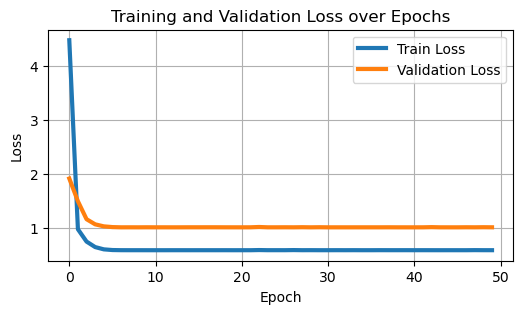

In [41]:
for dropout in dropout_list:
    for lr in lr_list:
        for weight_decay in weight_decay_list:
            print(f"Model Number: {model_no}")
            print(f"Learning Rate: {lr}")
            print(f"Weight Decay: {weight_decay}")
            print(f"Dropout: {dropout}")

            # Initialize and train the model
            model = Complex_Model(input_size, dropout)
            validation_mae, validation_loss, train_mae, train_loss, test_mae = train_and_evaluate(
                model, df, learning_rate=lr, weight_decay=weight_decay
            )

            # Record the results
            results = pd.concat([results, pd.DataFrame({
                "model_no": model_no,
                "model_type": "Complex",
                "learning_rate": lr,
                "weight_decay": weight_decay,
                "validation_mae": validation_mae[-1],
                "validation_loss": validation_loss[-1],
                "train_mae": train_mae[-1],
                "train_loss": train_loss[-1],
                "test_mae": test_mae
            }, index=[0])], ignore_index=True)
        
            model_no += 1


# Evaluation

In [69]:
results.sort_values('test_mae').head()[['model_no', 'model_type', 'learning_rate', 'weight_decay',
       'validation_mae', 'train_mae','test_mae']]

,model_no,model_type,learning_rate,weight_decay,validation_mae,train_mae,test_mae
24,25,Complex,0.060312,0.000149,0.779427,0.859790,0.788373
29,30,Complex,0.019423,0.000103,0.786629,0.890166,0.794950
19,20,Complex,0.065136,0.000163,0.787375,3.232416,0.795632
0,1,Basic,0.060312,0.000149,0.794036,0.804684,0.801714
25,26,Complex,0.060312,0.000163,0.794621,0.791518,0.802249


In [48]:
best_results = results[(results['model_no'] == 25) | (results['model_no'] == 1)]
best_results['test_train_difference_mae'] = best_results.test_mae - best_results.train_mae

In [72]:
best_results[['model_no', 'model_type', 'validation_mae', 'train_mae','test_mae', 'test_train_difference_mae']]

,model_no,model_type,validation_mae,train_mae,test_mae,test_train_difference_mae
0,1,Basic,0.794036,0.804684,0.801714,-0.002970
24,25,Complex,0.779427,0.859790,0.788373,-0.071417


In [55]:
complex_df = results[results['model_type'] == 'Complex']
basic_df = results[results['model_type'] == 'Basic']
complex_maes = complex_df['test_mae'].values
basic_maes = basic_df['test_mae'].values

In [71]:
print("Basic model average MAE:", basic_maes.mean())
print("Complex model average MAE:", complex_maes.mean())

Basic model average MAE: 0.8603893
Complex model average MAE: 1.4409344


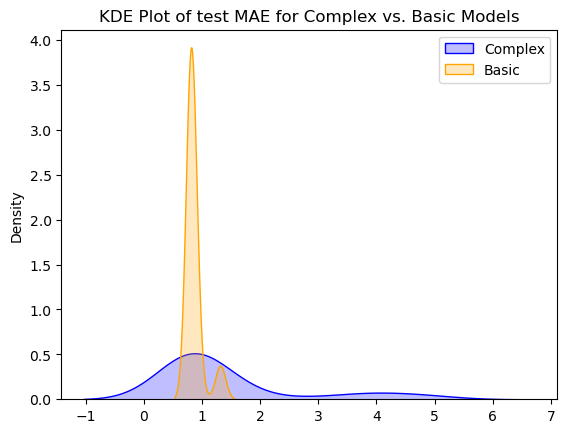

In [61]:
sns.kdeplot(complex_maes, shade=True, label='Complex', color='blue')
sns.kdeplot(basic_maes, shade=True, label='Basic', color='orange')
plt.title('KDE Plot of test MAE for Complex vs. Basic Models')
plt.legend()
plt.show()